In [33]:
# Read in existing demo

import pickle

demo = pickle.load(open('/home/anton/Documents/Yale/HCP/demographics.pkl', 'rb'))

print('Done')

Done


In [34]:
# List fields

desc = sorted(list(demo.keys()))

fields = desc

types = ['continuous', 'continuous', 'continuous', 'continuous',
         'categorical', 'continuous', 'continuous', 'continuous',
         'categorical', 'categorical', 'continuous', 'continuous',
         'continuous', 'continuous'
        ]

In [35]:
# Get subs with all values

keepSubs = []

for sub in demo['Age_in_Yrs']:
    exclude = False
    for field in list(demo.keys()):
        if sub not in demo[field]:
            exclude = True
    if not exclude:
        keepSubs.append(sub)

print(len(keepSubs))

1067


In [36]:
# Get FC

import numpy as np

fcsPkl = pickle.load(open('/home/anton/Documents/Yale/HCP/fcs_ya.pkl', 'rb'))
fcs = []

for sub in keepSubs:
    sub = str(sub)
    if sub in fcsPkl:
        fcs.append(fcsPkl[sub])

x = np.stack(fcs)

print(len(x))

456


In [37]:
for i in range(len(fields)):
    print(i, fields[i])

0 Age_in_Yrs
1 BMI
2 BPDiastolic
3 BPSystolic
4 Gender
5 Height
6 Hematocrit_1
7 PSQI_Score
8 Race
9 SSAGA_Mj_Use
10 Strength_Unadj
11 Total_Any_Tobacco_7days
12 Total_Drinks_7days
13 Weight


In [38]:
demos = [[] for field in fields]

for sub in keepSubs:
    if str(sub) in fcsPkl:
        for i in range(len(fields)):
            if fields[i] == 'Gender':
                val = int(demo[fields[i]][sub] == 'M')
            elif fields[i] == 'Race':
                val = int(demo[fields[i]][sub] == 'White')
            else:
                val = demo[fields[i]][sub]
            demos[i].append(val)

print('Done')

Done


In [75]:
# Get real subjects

count = 0
real_grp1 = []
real_grp2 = []

for sub in keepSubs:
    if str(sub) in fcsPkl:
        a = demos[0][count]
        s = demos[1][count]
        if s < 22:
            real_grp1.append(x[count])
        elif a > 27:
            real_grp2.append(x[count])
        count += 1

real_grp1 = np.stack(real_grp1)
real_grp2 = np.stack(real_grp2)

print(len(real_grp1))
print(len(real_grp2))

128
192


In [66]:
# Get synthetic subjects

import sys

sys.path.append('/home/anton/Documents/Tulane/Research/demo-vae/pip/src/')

from demovae import DemoVAE

field = 'BMI'

vae = DemoVAE(pperiod=50, use_cuda=True, nepochs=5000, latent_dim=100, weight_decay=0, lr=5e-5, loss_rec_mult=1e3,
              loss_pred_mult=0.01, loss_C_mult=1e4)
vae.load(f'/home/anton/Documents/Yale/HCP/VAE_Models/456_subs/{field}.pkl')

print('Done')

/home/anton/Documents/Tulane/Research/demo-vae/pip/src/demovae/sklearn.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dct = torch.load(path)


Done


In [67]:
import pickle

dct = pickle.load(open(f'/home/anton/Documents/Yale/HCP/VAE_Models/456_subs/demos_{field}.pkl', 'rb'))

print(list(dct.keys()))
print('Done')

['demos', 'types']
Done


In [68]:
dct['demos'][4][:20]

array([22.96, 30.27, 22.2 , 20.42, 26.77, 25.85, 19.91, 25.34, 24.17,
       16.65, 25.96, 23.87, 25.16, 18.42, 19.57, 27.25, 21.37, 28.82,
       24.62, 23.96])

In [80]:
import numpy as np

synth_grp1 = []
synth_grp2 = []

for i in range(1):
    synth = vae.transform(x, dct['demos'], dct['types'])
    synth += 0.09*np.random.normal(size=x.shape)
    for j in range(len(dct['demos'][0])):
        a = dct['demos'][0][j]
        s = dct['demos'][4][j]
        if s < 23:
            synth_grp1.append(synth[j])
        elif a > 28:
            synth_grp2.append(synth[j])

synth_grp1 = np.stack(synth_grp1)
synth_grp2 = np.stack(synth_grp2)

print(len(synth_grp1))
print(len(synth_grp2))

179
146


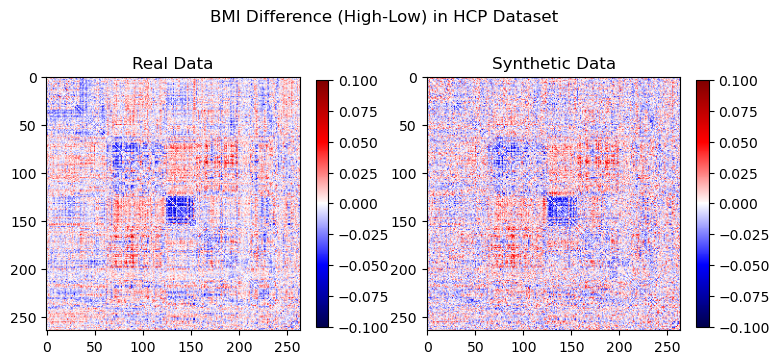

In [81]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

divis = [0,30,35,49,62,120,125,156,181,199,212,221,232,236,264]
labels = ['SMTH','SMTM','CNG','AUD','DMN','MEM','VIS','FRNT','SAL','SUB','VTRL','DRSL','CBL','UNK']

def getlabel(i):
    for j in range(len(divis)):
        if i >= divis[j] and i < divis[j+1]:
            return labels[j]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

real_diff = np.mean(real_grp2, axis=0)-np.mean(real_grp1, axis=0)
real_diff = vec2mat(real_diff)

synth_diff = np.mean(synth_grp2, axis=0)-np.mean(synth_grp1, axis=0)
synth_diff = vec2mat(synth_diff)

norm = TwoSlopeNorm(vmax=0.1, vmin=-0.1, vcenter=0)

fig, ax = plt.subplots(1,2,figsize=(9,4))

pos = ax[0].imshow(real_diff, cmap='seismic', norm=norm)
fig.colorbar(pos, ax=ax[0], shrink=0.8)

pos = ax[1].imshow(synth_diff, cmap='seismic', norm=norm)
fig.colorbar(pos, ax=ax[1], shrink=0.8)

ax[0].set_title('Real Data')
ax[1].set_title('Synthetic Data')

fig.suptitle('BMI Difference (High-Low) in HCP Dataset')
fig.show()
fig.savefig('/home/anton/Documents/Yale/HCP/Figures/RealSynthBMI.pdf')